In [60]:
import numpy as np
import pandas as pd

#from tensorflow_docs.vis import embed
import matplotlib.pyplot as plt
import numpy as np
import imageio

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer

In [61]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.regularizers import l2

In [62]:
# Set GPU memory growth so that I can still work on my PC with other GPU hungry apps..
gpu_devices = tf.config.experimental.list_physical_devices('GPU')

if gpu_devices:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
  except RuntimeError as e:
    # Visible devices must be set at program startup
    print(e)

# To use bloody mixed precision on my GPUs
#tf.keras.mixed_precision.set_global_policy('mixed_float16')

## Resources

Vanilla conditonal GAN: https://keras.io/examples/generative/conditional_gan/
Wasserstein GAN: https://keras.io/examples/generative/wgan_gp/

## Loading data

In [63]:
# Load the data my man
airfoils_opt_995 = np.load('./data/airfoils_opt_995.npy')
aoas_opt_995     = np.load('./data/aoas_opt_995.npy')
inp_paras_995    = np.load('./data/inp_paras_995.npy')

In [64]:
# 995 airfoils, 192 points, 2 for x and y
airfoils_opt_995.shape

(995, 192, 2)

In [65]:
# optimal angle of attack
aoas_opt_995.shape

(995,)

In [66]:
# Ma, Re, Lift
inp_paras_995.shape

(995, 3)

## Defining the inputs X and outputs Y of the GAN

In [67]:
X = inp_paras_995
Y = airfoils_opt_995

# Reshaping Y to get a 2D array
nsamples, nx, ny = Y.shape
Y = Y.reshape((nsamples,nx*ny))
Y.shape

(995, 384)

## Split in training, validation and test sets

In [68]:
scaler_x = StandardScaler() #GaussRankScaler() #QuantileTransformer(output_distribution='normal') #PowerTransformer() #MinMaxScaler(feature_range=(-1, 1)) # StandardScaler()
scaler_y = StandardScaler() #GaussRankScaler() #QuantileTransformer(output_distribution='normal') #PowerTransformer() #MinMaxScaler(feature_range=(-1, 1)) # StandardScaler() #MinMaxScaler()

# Split randomly the data into test and validation sets to avoid overfitting during training.
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.20, random_state=1)
#X_valid, X_test, Y_valid, Y_test   = train_test_split(X_valid, Y_valid, test_size=0.5, random_state=1)

# Fit the scalers on the training data only!
scaler_x.fit(X_train)
scaler_y.fit(Y_train)

# Standardize the sets
x_train = scaler_x.transform(X_train).astype(np.float32)
x_valid = scaler_x.transform(X_valid).astype(np.float32)
#x_test  = scaler_x.transform(X_test).astype(np.float32)

y_train = scaler_y.transform(Y_train).astype(np.float32)
y_valid = scaler_y.transform(Y_valid).astype(np.float32)
#y_test  = scaler_y.transform(Y_test).astype(np.float32)

## Constants and hyperparameters

In [69]:
batch_size = 32
BATCH_SIZE = batch_size
num_channels = Y.shape[1] #1
num_classes = 0 #10
image_size = 28
latent_dim = X.shape[1] #128
n_neurons = 30
noise_dim = 100

## Loading the dataset and preprocessing it

In [70]:
# labels -> op
# digits -> airfoils
all_op = np.concatenate([x_train, x_valid])
all_airfoils = np.concatenate([y_train, y_valid])
#nx, ny = all_airfoils.shape
#all_airfoils = np.reshape(all_airfoils,(nx,ny,1))

# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_airfoils, all_op))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training airfoils: {all_airfoils.shape}")
print(f"Shape of training op: {all_op.shape}")

Shape of training airfoils: (995, 384)
Shape of training op: (995, 3)


## Calculating the number of input channel for the generator and discriminator

In [71]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

3 384


## Creating the discriminator and generator

In [72]:
# Create the discriminator.
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=(discriminator_in_channels,)),
        layers.ReLU(),
        layers.Dense(n_neurons),
        layers.ReLU(),
        layers.Dense(n_neurons),
        layers.ReLU(),
        layers.Dense(n_neurons),
        layers.ReLU(),
        layers.Dense(1),
        layers.Softmax()
    ],
    name="discriminator",
)

activation = 'relu'
k_ini       = 'he_uniform'
L2_pen     = 1e-8
nb_neurons = 100
nb_layers  = 3
optimizer='Adam'

model_ANN = Sequential()

# input layer
model_ANN.add(Dense(nb_neurons, input_dim=(discriminator_in_channels), activation=activation, kernel_initializer=k_ini,dtype=tf.float32))

# hidden layers
for i in range(nb_layers):
    if i == 0:
        if optimizer == 'NGA' or optimizer == 'CMA':
            dense_layer = Dense(nb_neurons, activation=activation, kernel_initializer=k_ini,dtype=tf.float32)(input_layer)
        else:
            model_ANN.add(Dense(nb_neurons, activation=activation, kernel_initializer=k_ini, kernel_regularizer=l2(L2_pen), dtype=tf.float32))
    elif i == (nb_layers-1): # Last layer
        if optimizer == 'NGA' or optimizer == 'CMA':
            dense_layer = Dense(nb_neurons, activation=activation, kernel_initializer=k_ini,dtype=tf.float32)(dense_layer)
        else:
            model_ANN.add(Dense(nb_neurons, activation=activation, kernel_initializer=k_ini, kernel_regularizer=l2(L2_pen), dtype=tf.float32))
    else:
        if optimizer == 'NGA' or optimizer == 'CMA':
            dense_layer = Dense(nb_neurons, activation=activation, kernel_initializer=k_ini,dtype=tf.float32)(dense_layer)
        else:
            model_ANN.add(Dense(nb_neurons, activation=activation, kernel_initializer=k_ini, kernel_regularizer=l2(L2_pen), dtype=tf.float32))
# output layer
model_ANN.add(Dense(1, dtype=tf.float32))

d_model = model_ANN

# Create the generator.
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels+noise_dim,)),
        layers.ReLU(),
        layers.Dense(n_neurons),
        layers.ReLU(),
        layers.Dense(n_neurons),
        layers.ReLU(),
        layers.Dense(num_channels),
        layers.ReLU(),
    ],
    name="generator",
)

model_ANN = Sequential()

# input layer
model_ANN.add(Dense(nb_neurons, input_dim=(generator_in_channels+noise_dim), activation=activation, kernel_initializer=k_ini,dtype=tf.float32))

# hidden layers
for i in range(nb_layers):
    if i == 0:
        if optimizer == 'NGA' or optimizer == 'CMA':
            dense_layer = Dense(nb_neurons, activation=activation, kernel_initializer=k_ini,dtype=tf.float32)(input_layer)
        else:
            model_ANN.add(Dense(nb_neurons, activation=activation, kernel_initializer=k_ini, kernel_regularizer=l2(L2_pen), dtype=tf.float32))
    elif i == (nb_layers-1): # Last layer
        if optimizer == 'NGA' or optimizer == 'CMA':
            dense_layer = Dense(nb_neurons, activation=activation, kernel_initializer=k_ini,dtype=tf.float32)(dense_layer)
        else:
            model_ANN.add(Dense(nb_neurons, activation=activation, kernel_initializer=k_ini, kernel_regularizer=l2(L2_pen), dtype=tf.float32))
    else:
        if optimizer == 'NGA' or optimizer == 'CMA':
            dense_layer = Dense(nb_neurons, activation=activation, kernel_initializer=k_ini,dtype=tf.float32)(dense_layer)
        else:
            model_ANN.add(Dense(nb_neurons, activation=activation, kernel_initializer=k_ini, kernel_regularizer=l2(L2_pen), dtype=tf.float32))
# output layer
model_ANN.add(Dense(num_channels, dtype=tf.float32))

g_model = model_ANN

## Creating a Conditional vanilla GAN model

In [73]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
    
    # all good till here
    def train_step(self, data):
        # Unpack the data.
        # real_images -> real_airfoils
        # one_hot_labels -> op
        real_airfoils, op = data

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_airfoils)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim), dtype=tf.float32)
        random_vector_labels = tf.concat(
            [random_latent_vectors, op], axis=1
        )
        print('random_vector_labels shape', random_vector_labels.shape)
        # all good till here
        
        # Decode the noise (guided by labels) to fake airfoils.
        generated_airfoils = self.generator(random_vector_labels)
        print('generated_airfoils shape', generated_airfoils.shape)

        # Combine them with real airfoils. 
        fake_airfoils = generated_airfoils
        print('fake_airfoils shape', fake_airfoils.shape)
        real_airfoils = real_airfoils
        print('real_airfoils shape', real_airfoils.shape)
        combined_airfoils = tf.concat(
            [fake_airfoils, real_airfoils], axis=0
        )
        print('combined_airfoils shape', combined_airfoils.shape)

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1), dtype=tf.float32), tf.zeros((batch_size, 1), dtype=tf.float32)], axis=0
        )
        print('tf.ones((batch_size, 1)', tf.ones((batch_size, 1)))
        print('labels shape', labels.shape)

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_airfoils)
            print('predictions shape', predictions.shape)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim), dtype=tf.float32)
        print('random_latent_vectors shape', random_latent_vectors.shape)
        random_vector_labels = tf.concat(
            [random_latent_vectors, op], axis=1
        )
        print('random_vector_labels shape', random_vector_labels.shape)

        # Assemble labels that say "all real airfoils".
        misleading_labels = tf.zeros((batch_size, 1))
        print('misleading_labels shape', misleading_labels.shape)

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_airfoils = self.generator(random_vector_labels)
            print('fake_airfoils shape', fake_airfoils.shape)
            #fake_image_and_labels = tf.concat([fake_airfoils, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_airfoils)
            print('predictions shape', predictions.shape)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


## Creating a Conditional Wasserstein GAN model

In [74]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_airfoils, fake_airfoils):
        """Calculates the gradient penalty.

        This loss is calculated on an interpolated airfoil
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, tf.shape(real_airfoils)[1]], 0.0, 1.0)
        diff = fake_airfoils - real_airfoils
        interpolated = real_airfoils + alpha * diff

        # good till here
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        
        real_airfoils, op = data
        
        if isinstance(real_airfoils, tuple):
            real_airfoils = real_airfoils[0]

        # Get the batch size
        batch_size = tf.shape(real_airfoils)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim), dtype=tf.float32)
            random_vector_labels = tf.concat(
                [random_latent_vectors, op], axis=1
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_airfoils = self.generator(random_vector_labels, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_airfoils, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_airfoils, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_afl=real_logits, fake_afl=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_airfoils, fake_airfoils)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )
        #good till here
        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim), dtype=tf.float32)
        random_vector_labels = tf.concat([random_latent_vectors, op], axis=1)
        
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_airfoils = self.generator(random_vector_labels, training=True)
            # Get the discriminator logits for fake images
            gen_afl_logits = self.discriminator(generated_airfoils, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_afl_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}


## Training the Wasserstein Conditional GAN

In [75]:
#Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_afl, fake_afl):
    real_loss = tf.reduce_mean(real_afl)
    fake_loss = tf.reduce_mean(fake_afl)
    return fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_afl):
    return -tf.reduce_mean(fake_afl)


# Set the number of epochs for trainining.
epochs = 200


# Get the wgan model
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3,
)

# Compile the wgan model
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

# Start training
wgan.fit(dataset, batch_size=BATCH_SIZE, epochs=epochs)

Epoch 1/200
32/32 [==============================] - 3s 38ms/step - d_loss: -6.8665 - g_loss: 0.5769
Epoch 2/200
32/32 [==============================] - 1s 31ms/step - d_loss: -16.6118 - g_loss: -0.3938
Epoch 3/200
32/32 [==============================] - 1s 31ms/step - d_loss: -18.6725 - g_loss: -0.2252
Epoch 4/200
32/32 [==============================] - 1s 31ms/step - d_loss: -19.4598 - g_loss: 0.2344
Epoch 5/200
32/32 [==============================] - 1s 31ms/step - d_loss: -20.6804 - g_loss: 0.2758
Epoch 6/200
32/32 [==============================] - 1s 32ms/step - d_loss: -21.3519 - g_loss: 0.8886
Epoch 7/200
32/32 [==============================] - 1s 31ms/step - d_loss: -22.1508 - g_loss: 1.5694
Epoch 8/200
32/32 [==============================] - 1s 23ms/step - d_loss: -22.2696 - g_loss: 1.7358
Epoch 9/200
32/32 [==============================] - 1s 25ms/step - d_loss: -21.7962 - g_loss: 0.2109
Epoch 10/200
32/32 [==============================] - 1s 29ms/step - d_loss: -21.

32/32 [==============================] - 1s 31ms/step - d_loss: -8.4803 - g_loss: 4.1299
Epoch 81/200
32/32 [==============================] - 1s 31ms/step - d_loss: -8.8514 - g_loss: 5.7073
Epoch 82/200
32/32 [==============================] - 1s 31ms/step - d_loss: -8.7058 - g_loss: 4.7662
Epoch 83/200
32/32 [==============================] - 1s 30ms/step - d_loss: -9.9020 - g_loss: 4.9393
Epoch 84/200
32/32 [==============================] - 1s 31ms/step - d_loss: -8.8505 - g_loss: 4.6734
Epoch 85/200
32/32 [==============================] - 1s 31ms/step - d_loss: -9.6746 - g_loss: 4.6164
Epoch 86/200
32/32 [==============================] - 1s 31ms/step - d_loss: -9.2269 - g_loss: 6.1182
Epoch 87/200
32/32 [==============================] - 1s 31ms/step - d_loss: -8.2955 - g_loss: 5.5952
Epoch 88/200
32/32 [==============================] - 1s 31ms/step - d_loss: -10.0861 - g_loss: 4.8473
Epoch 89/200
32/32 [==============================] - 1s 33ms/step - d_loss: -9.0459 - g_loss:

32/32 [==============================] - 1s 31ms/step - d_loss: -9.3146 - g_loss: 7.2051
Epoch 160/200
32/32 [==============================] - 1s 31ms/step - d_loss: -7.0803 - g_loss: 6.8128
Epoch 161/200
32/32 [==============================] - 1s 31ms/step - d_loss: -8.8654 - g_loss: 7.3133
Epoch 162/200
32/32 [==============================] - 1s 31ms/step - d_loss: -8.4182 - g_loss: 8.4963
Epoch 163/200
32/32 [==============================] - 1s 31ms/step - d_loss: -7.4517 - g_loss: 8.0122
Epoch 164/200
32/32 [==============================] - 1s 31ms/step - d_loss: -7.3110 - g_loss: 7.8445
Epoch 165/200
32/32 [==============================] - 1s 31ms/step - d_loss: -7.1643 - g_loss: 7.9867
Epoch 166/200
32/32 [==============================] - 1s 31ms/step - d_loss: -7.1892 - g_loss: 8.2098
Epoch 167/200
32/32 [==============================] - 1s 31ms/step - d_loss: -7.9435 - g_loss: 7.5425
Epoch 168/200
32/32 [==============================] - 1s 31ms/step - d_loss: -8.1212 -

## Plot WcGAN losses

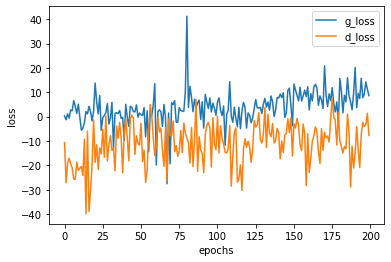

In [92]:
# record history
plt.plot([i for i in range(epochs)], wgan.history.history['g_loss'],label ='g_loss')
plt.plot([i for i in range(epochs)], wgan.history.history['d_loss'],label ='d_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend() 
plt.savefig('./losses/wgan_loss.png')
plt.show()

## Training the Conditional vanilla GAN

In [77]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=noise_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.002),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.002),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

cond_gan.fit(dataset, epochs=200)

Epoch 1/200
random_vector_labels shape (None, 103)
generated_airfoils shape (None, 384)
fake_airfoils shape (None, 384)
real_airfoils shape (None, 384)
combined_airfoils shape (None, 384)
tf.ones((batch_size, 1) Tensor("ones_1:0", shape=(None, 1), dtype=float32)
labels shape (None, 1)
predictions shape (None, 1)
random_latent_vectors shape (None, 100)
random_vector_labels shape (None, 103)
misleading_labels shape (None, 1)
fake_airfoils shape (None, 384)
predictions shape (None, 1)
random_vector_labels shape (None, 103)
generated_airfoils shape (None, 384)
fake_airfoils shape (None, 384)
real_airfoils shape (None, 384)
combined_airfoils shape (None, 384)
tf.ones((batch_size, 1) Tensor("ones_1:0", shape=(None, 1), dtype=float32)
labels shape (None, 1)
predictions shape (None, 1)
random_latent_vectors shape (None, 100)
random_vector_labels shape (None, 103)
misleading_labels shape (None, 1)
fake_airfoils shape (None, 384)
predictions shape (None, 1)
32/32 [==============================]

32/32 [==============================] - 0s 12ms/step - g_loss: 1.3133 - d_loss: 0.8133
Epoch 74/200
32/32 [==============================] - 0s 11ms/step - g_loss: 1.3133 - d_loss: 0.8133
Epoch 75/200
32/32 [==============================] - 0s 9ms/step - g_loss: 1.3133 - d_loss: 0.8133
Epoch 76/200
32/32 [==============================] - 0s 10ms/step - g_loss: 1.3133 - d_loss: 0.8133
Epoch 77/200
32/32 [==============================] - 0s 8ms/step - g_loss: 1.3133 - d_loss: 0.8133
Epoch 78/200
32/32 [==============================] - 0s 10ms/step - g_loss: 1.3133 - d_loss: 0.8133
Epoch 79/200
32/32 [==============================] - 0s 11ms/step - g_loss: 1.3133 - d_loss: 0.8133
Epoch 80/200
32/32 [==============================] - 0s 9ms/step - g_loss: 1.3133 - d_loss: 0.8133
Epoch 81/200
32/32 [==============================] - 0s 9ms/step - g_loss: 1.3133 - d_loss: 0.8133
Epoch 82/200
32/32 [==============================] - 0s 8ms/step - g_loss: 1.3133 - d_loss: 0.8133
Epoch 83

32/32 [==============================] - 0s 10ms/step - g_loss: 1.3133 - d_loss: 0.8133
Epoch 155/200
32/32 [==============================] - 0s 9ms/step - g_loss: 1.3133 - d_loss: 0.8133
Epoch 156/200
32/32 [==============================] - 0s 11ms/step - g_loss: 1.3133 - d_loss: 0.8133
Epoch 157/200
32/32 [==============================] - 0s 8ms/step - g_loss: 1.3133 - d_loss: 0.8133
Epoch 158/200
32/32 [==============================] - 0s 8ms/step - g_loss: 1.3133 - d_loss: 0.8133
Epoch 159/200
32/32 [==============================] - 0s 7ms/step - g_loss: 1.3133 - d_loss: 0.8133
Epoch 160/200
32/32 [==============================] - 0s 7ms/step - g_loss: 1.3133 - d_loss: 0.8133
Epoch 161/200
32/32 [==============================] - 0s 7ms/step - g_loss: 1.3133 - d_loss: 0.8133
Epoch 162/200
32/32 [==============================] - 0s 7ms/step - g_loss: 1.3133 - d_loss: 0.8133
Epoch 163/200
32/32 [==============================] - 0s 8ms/step - g_loss: 1.3133 - d_loss: 0.8133
Ep

## Plot vanilla cGan

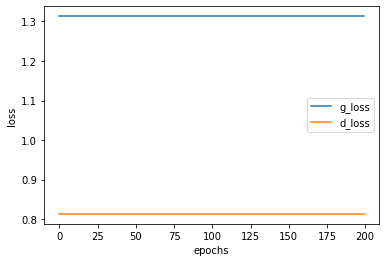

In [90]:
# record history
plt.plot([i for i in range(epochs)], cond_gan.history.history['g_loss'],label ='g_loss')
plt.plot([i for i in range(epochs)], cond_gan.history.history['d_loss'],label ='d_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend() 
plt.savefig('./losses/cgan_loss.png')
plt.show()

## Predict with the generator and Plot the airfoil for WcGAN

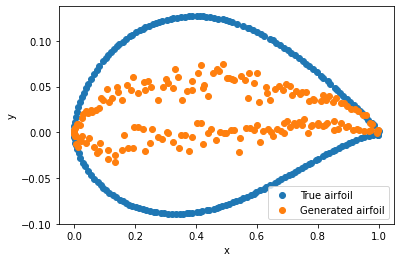

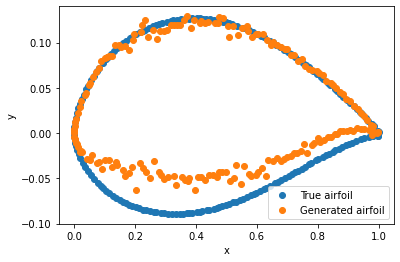

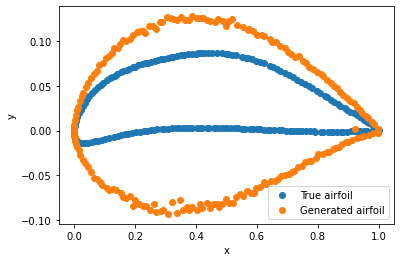

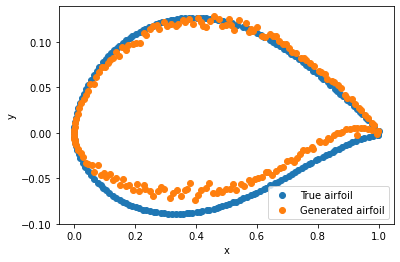

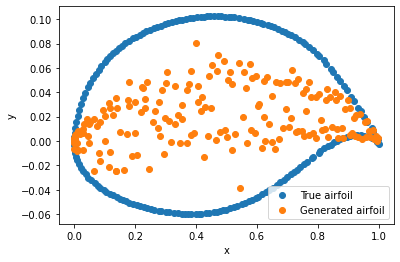

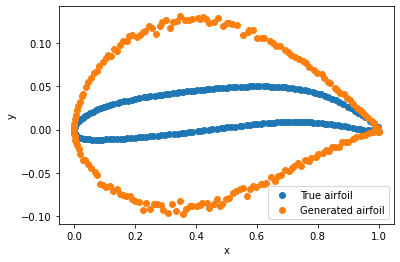

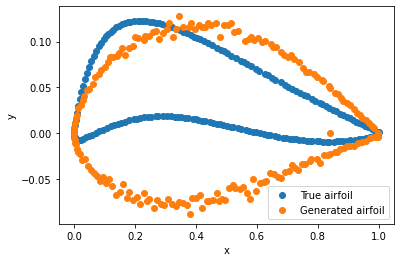

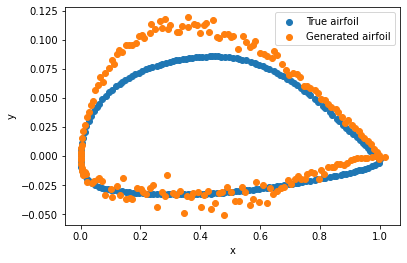

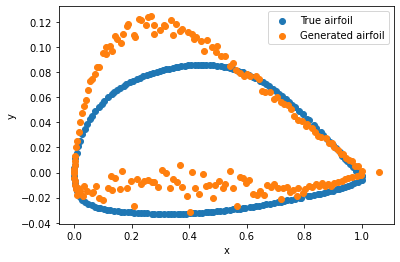

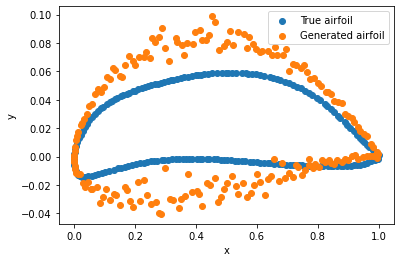

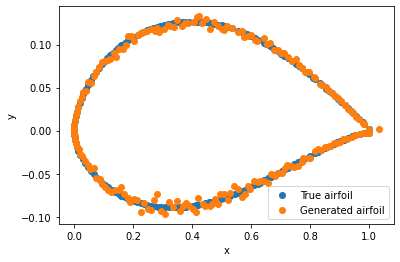

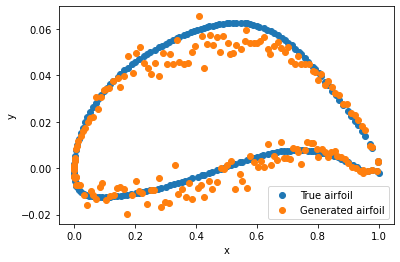

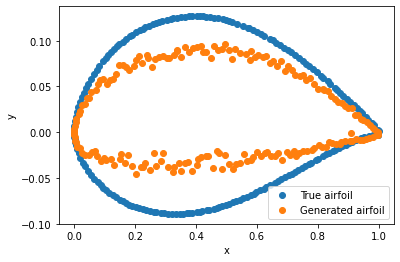

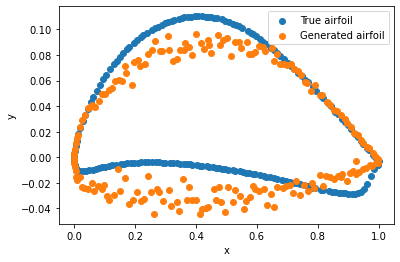

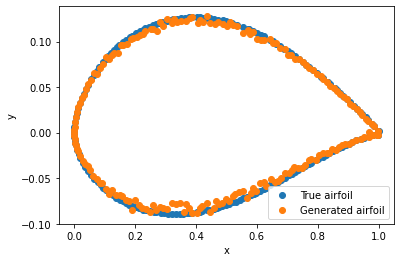

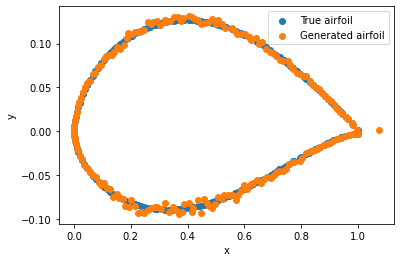

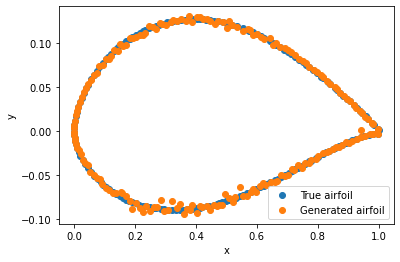

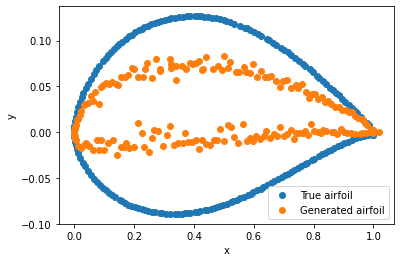

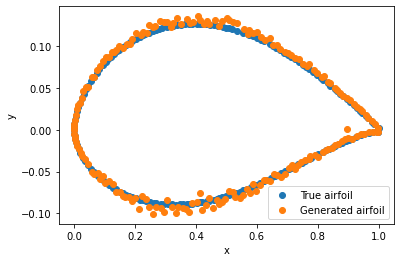

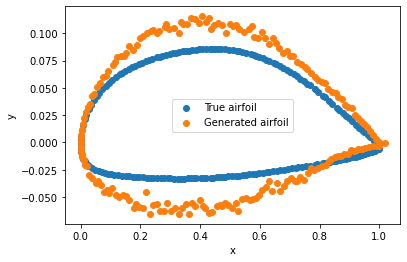

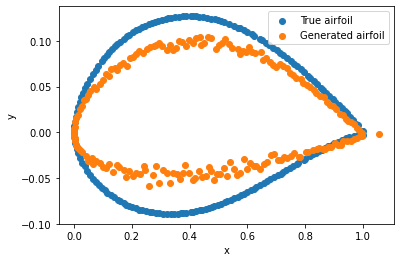

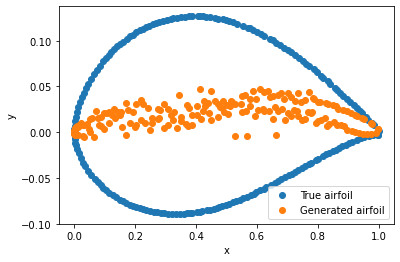

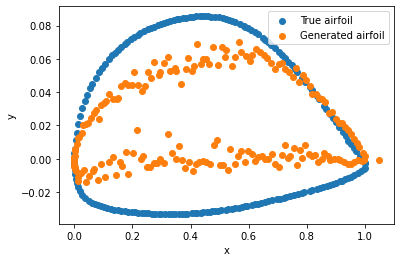

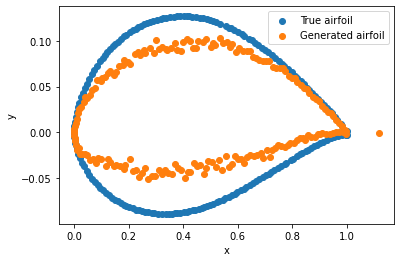

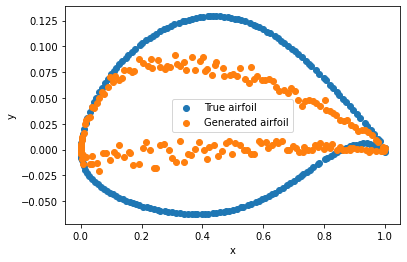

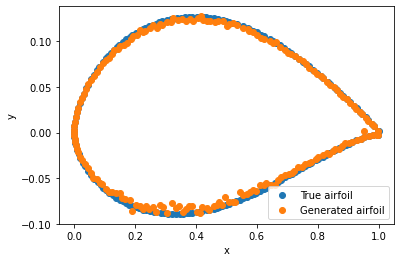

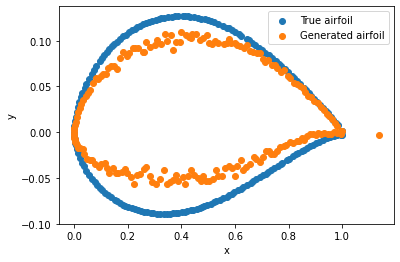

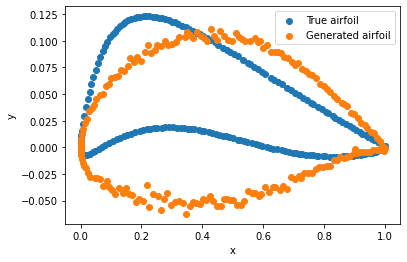

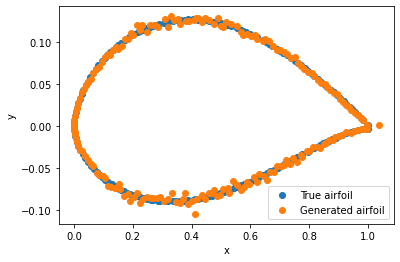

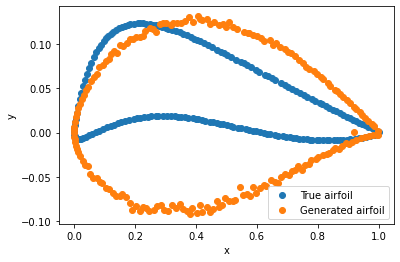

In [87]:
# We first extract the trained generator from our Conditiona GAN.
trained_gen = wgan.generator #cond_gan.generator

for i in range(30):
    # generate noise
    interpolation_noise = tf.random.normal(shape=(1, noise_dim))
    # concatenate it with a test row
    n_row = i
    input_test=tf.concat([interpolation_noise,np.reshape(x_valid[n_row,:],(1,-1))], axis=1)
    # send it to trained_gen
    Y_gen = scaler_y.inverse_transform(trained_gen(input_test))
    Y_gen = np.reshape(Y_gen,(1,-1,2))
    # Reshape the test airfoi
    Y_test_row = Y_valid[n_row,:]
    Y_test_row = np.reshape(Y_test_row,(1,-1,2))
    interpolation_noise

    plt.scatter(Y_test_row[:,:,0], Y_test_row[:,:,1],label ='True airfoil')
    plt.scatter(Y_gen[:,:,0], Y_gen[:,:,1],label ='Generated airfoil')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend() 
    plt.savefig('./results/wcgan_airoil'+str(i)+'.png')
    plt.show()
    


## Predict with the generator and Plot the airfoil for cGAN

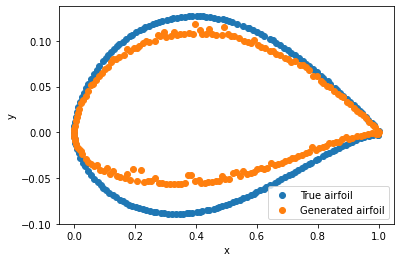

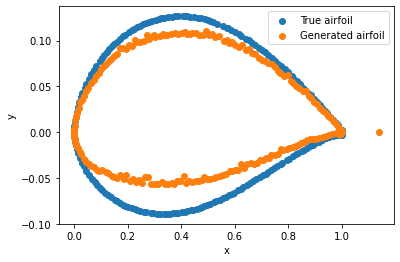

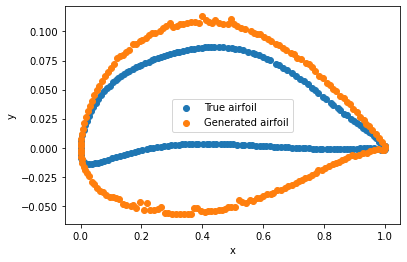

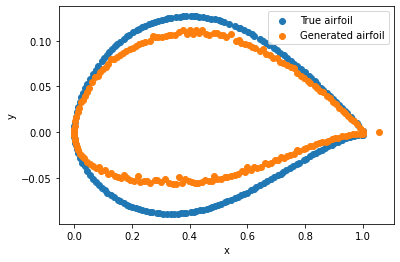

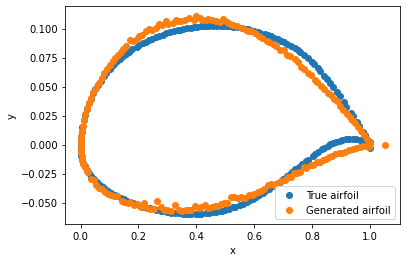

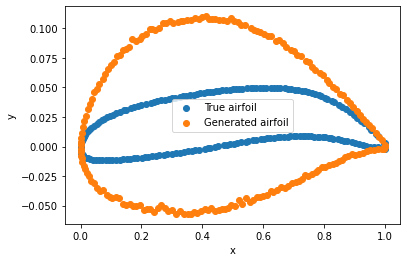

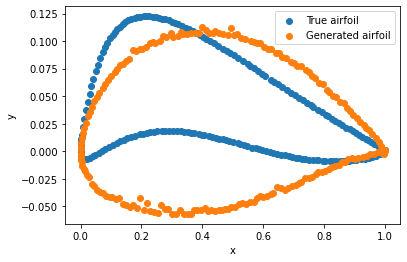

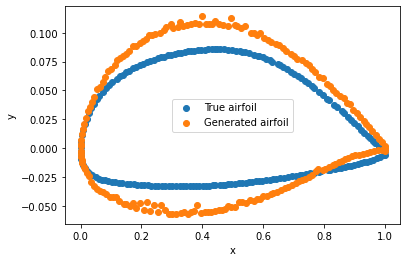

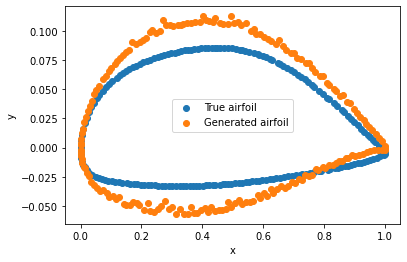

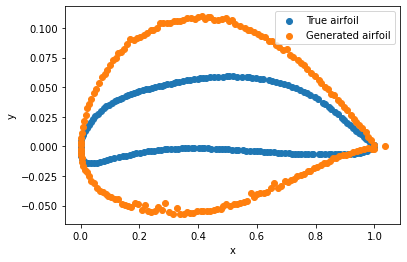

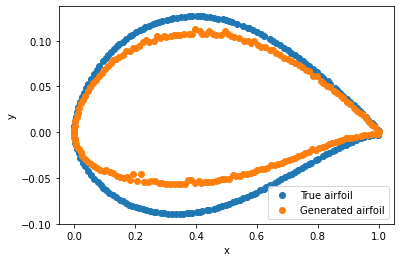

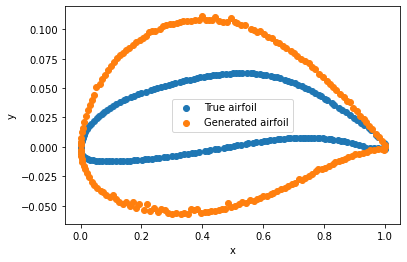

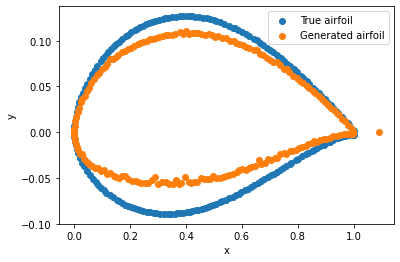

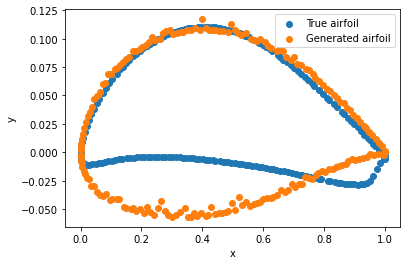

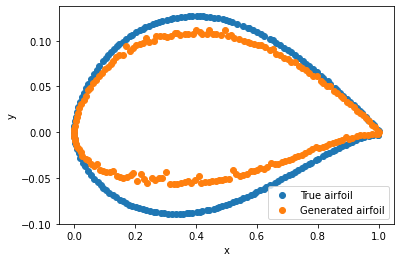

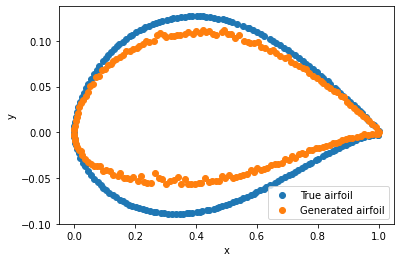

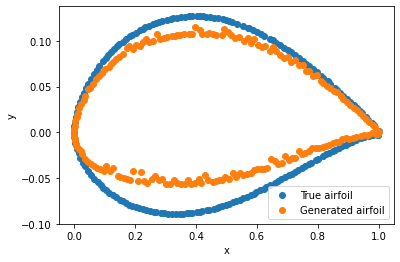

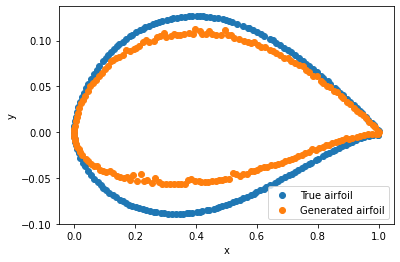

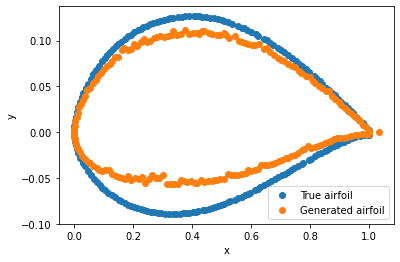

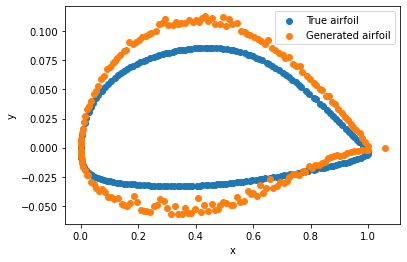

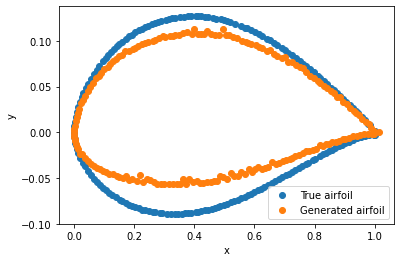

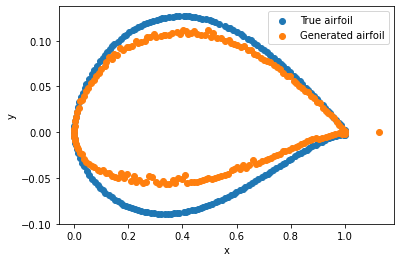

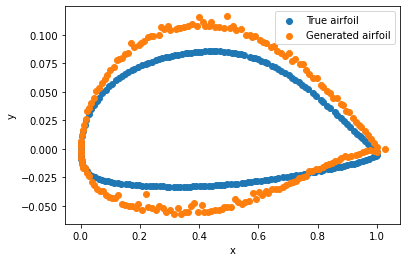

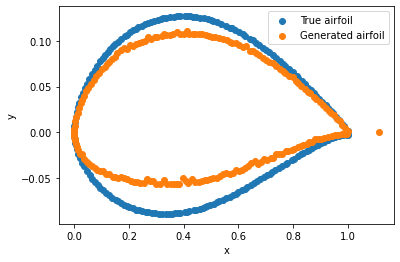

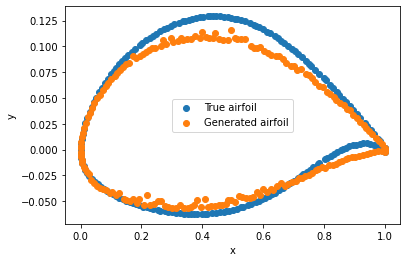

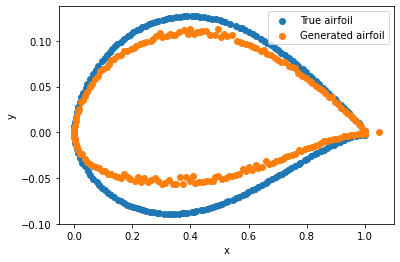

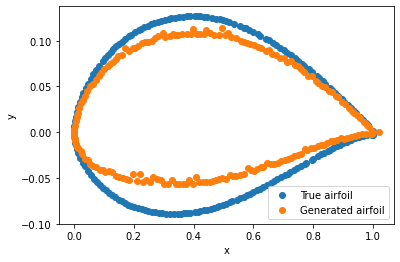

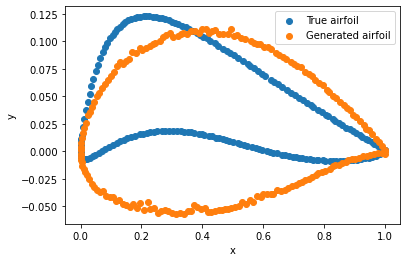

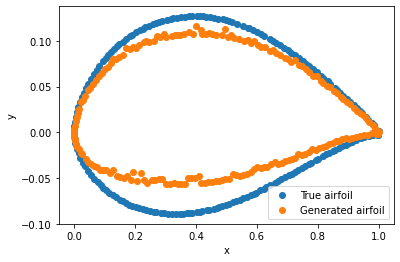

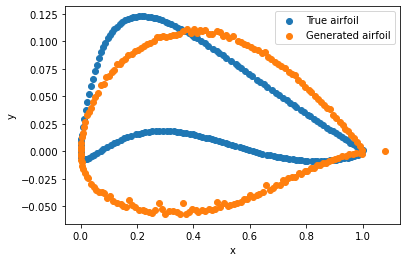

In [88]:
# We first extract the trained generator from our Conditiona GAN.
trained_gen = cond_gan.generator #cond_gan.generator

for i in range(30):
    # generate noise
    interpolation_noise = tf.random.normal(shape=(1, noise_dim))
    # concatenate it with a test row
    n_row = i
    input_test=tf.concat([interpolation_noise,np.reshape(x_valid[n_row,:],(1,-1))], axis=1)
    # send it to trained_gen
    Y_gen = scaler_y.inverse_transform(trained_gen(input_test))
    Y_gen = np.reshape(Y_gen,(1,-1,2))
    # Reshape the test airfoi
    Y_test_row = Y_valid[n_row,:]
    Y_test_row = np.reshape(Y_test_row,(1,-1,2))
    interpolation_noise
    
    plt.scatter(Y_test_row[:,:,0], Y_test_row[:,:,1],label ='True airfoil')
    plt.scatter(Y_gen[:,:,0], Y_gen[:,:,1],label ='Generated airfoil')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend() 
    plt.savefig('./results/cgan_airoil'+str(i)+'.png')
    plt.show()
    


## Maximum mean-discrepancy distance
From : https://www.kaggle.com/code/onurtunali/maximum-mean-discrepancy/notebook

In [93]:

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def MMD(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    
    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)
    
    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))
    
    if kernel == "multiscale":
        
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1
            
    if kernel == "rbf":
      
        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)
      
      

    return torch.mean(XX + YY - 2. * XY)

In [98]:
#%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import dirichlet 
from torch.distributions.multivariate_normal import MultivariateNormal 


m = 20 # sample size
x_mean = torch.zeros(2)+1
y_mean = torch.zeros(2)
x_cov = 2*torch.eye(2) # IMPORTANT: Covariance matrices must be positive definite
y_cov = 3*torch.eye(2) - 1

px = MultivariateNormal(x_mean, x_cov)
qy = MultivariateNormal(y_mean, y_cov)
x = px.sample([m]).to(device)
y = qy.sample([m]).to(device)

# generate noise
interpolation_noise = tf.random.normal(shape=(len(x_valid), noise_dim))
input_test=tf.concat([interpolation_noise,np.reshape(x_valid,(len(x_valid),-1))], axis=1)
# send it to trained_gen
Y_gen = scaler_y.inverse_transform(trained_gen(input_test))
#Y_gen = np.reshape(Y_gen,(1,-1,2))

result = MMD(Y_gen, Y_valid, kernel="multiscale")

print(f"MMD result of X and Y is {result.item()}")

# ---- Plotting setup ----

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4), dpi=100)
#plt.tight_layout() 
delta = 0.025

x1_val = np.linspace(-5, 5, num=m)
x2_val = np.linspace(-5, 5, num=m)

x1, x2 = np.meshgrid(x1_val, x2_val)

px_grid = torch.zeros(m,m)
qy_grid = torch.zeros(m,m)


for i in range(m):
    for j in range(m):
        px_grid[i,j] = multivariate_normal.pdf([x1_val[i],x2_val[j]], x_mean, x_cov)
        qy_grid[i,j] = multivariate_normal.pdf([x1_val[i],x2_val[j]], y_mean, y_cov)


CS1 = ax1.contourf(x1, x2, px_grid,100, cmap=plt.cm.YlGnBu)
ax1.set_title("Distribution of $X \sim P(X)$")
ax1.set_ylabel('$x_2$')
ax1.set_xlabel('$x_1$')
ax1.set_aspect('equal')
ax1.scatter(x[:10,0].cpu(), x[:10,1].cpu(), label="$X$ Samples", marker="o", facecolor="r", edgecolor="k")
ax1.legend()

CS2 = ax2.contourf(x1, x2, qy_grid,100, cmap=plt.cm.YlGnBu)
ax2.set_title("Distribution of $Y \sim Q(Y)$")
ax2.set_xlabel('$y_1$')
ax2.set_ylabel('$y_2$')
ax2.set_aspect('equal')
ax2.scatter(y[:10,0].cpu(), y[:10,1].cpu(), label="$Y$ Samples", marker="o", facecolor="r", edgecolor="k")
ax2.legend()
#ax1.axis([-2.5, 2.5, -2.5, 2.5])

# Add colorbar and title
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(CS2, cax=cbar_ax)
cbar.ax.set_ylabel('Density results')
plt.suptitle(f"MMD result: {round(result.item(),3)}",y=0.95, fontweight="bold")
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 't'